# CIFAR-10

In [1]:
import itertools
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from torch.utils import tensorboard
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models

random_seed = 20181401
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed)

display = display if "display" in vars(__builtins__) else print
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
writer = tensorboard.SummaryWriter()

display(device)

device(type='cuda', index=0)

In [2]:
learning_rate = 0.0001
training_epochs = 50
batch_size = 64

In [3]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
transform = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

cifar_10_train_dataset = datasets.CIFAR10(root="datasets/CIFAR10/", train=True, transform=transform, download=True)
cifar_10_test_dataset = datasets.CIFAR10(root="datasets/CIFAR10/", train=False, transform=transform, download=True)
cifar_10_train_loader = DataLoader(cifar_10_train_dataset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=2)
cifar_10_test_loader = DataLoader(cifar_10_test_dataset, batch_size=batch_size, shuffle=False, drop_last=True, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
writer.add_images("Sample Images", next(iter(cifar_10_test_loader))[0] * 0.5 + 0.5)
writer.flush()

In [5]:
class Model(nn.Module):
  def __init__(self):
    super().__init__()
    self.vgg16 = models.vgg16_bn(weights=models.VGG16_BN_Weights.IMAGENET1K_V1, num_classes=1000)
    self.final_layer = nn.Sequential(
      nn.BatchNorm1d(1000),
      nn.ReLU(True),
      nn.Dropout(0.5),
      nn.Linear(1000, 10)
    )
  
  def forward(self, x):
    out = self.vgg16(x)
    out = self.final_layer(out)
    return out

In [6]:
model = Model().to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.3, patience=5, threshold=0.0001)

display(model)
writer.add_graph(model, next(iter(cifar_10_test_loader))[0].to(device))
writer.flush()

Model(
  (vgg16): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): ReLU(inplace=True)
      (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (12): ReLU(inplace=True)
      (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilati

In [7]:
def validate():
  with torch.no_grad():
    model.eval()
    batch_count = len(cifar_10_test_loader)
    avg_cost = 0
    avg_accuracy = 0

    for x, y in cifar_10_test_loader:
      assert isinstance(x, torch.Tensor)
      assert isinstance(y, torch.Tensor)
      x = x.to(device)
      y = y.to(device)

      hypothesis = model(x)
      cost = criterion(hypothesis, y)
      prediction = torch.argmax(hypothesis, dim=1)
      avg_cost += cost.item() / batch_count
      avg_accuracy += (prediction == y).float().mean().item() / batch_count
    
    return avg_cost, avg_accuracy

In [8]:
display("epoch: 0 / validate cost: {} / validate accuracy: {:.3f}%".format(validate()[0], validate()[1] * 100))
best_accuracy = 0

for epoch in range(training_epochs):
  batch_count = len(cifar_10_train_loader)
  avg_cost = 0
  avg_accuracy = 0

  for x, y in cifar_10_train_loader:
    assert isinstance(x, torch.Tensor)
    assert isinstance(y, torch.Tensor)
    model.train()
    x = x.to(device)
    y = y.to(device)

    hypothesis = model(x)
    cost = criterion(hypothesis, y)
    prediction = torch.argmax(hypothesis, dim=1)
    avg_cost += cost.item() / batch_count
    avg_accuracy += (prediction == y).float().mean().item() / batch_count

    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
  
  validate_cost, validate_accuracy = validate()
  display("epoch: {} / train cost: {} / validate cost: {} / train accuracy: {:.3f}% / validate accuracy: {:.3f}% / lr: {}"
    .format(epoch + 1, avg_cost, validate_cost, avg_accuracy * 100, validate_accuracy * 100, optimizer.param_groups[0]["lr"]))
  writer.add_scalars("Cost", {"train": avg_cost, "validate": validate_cost}, epoch + 1)
  writer.add_scalars("Accuracy", {"train": avg_accuracy * 100, "validate": validate_accuracy * 100}, epoch + 1)
  writer.flush()

  if validate_accuracy > best_accuracy:
    best_accuracy = validate_accuracy
    torch.save(model.state_dict(), "models/vgg-cifar-10.pth")

  scheduler.step(validate_cost)

'epoch: 0 / validate cost: 3.6871845645782284 / validate accuracy: 10.146%'

'epoch: 1 / train cost: 0.7210500109249124 / validate cost: 0.3995352523067062 / train accuracy: 76.380% / validate accuracy: 86.809% / lr: 0.0001'

'epoch: 2 / train cost: 0.3109193241245155 / validate cost: 0.37059396686844354 / train accuracy: 90.065% / validate accuracy: 88.111% / lr: 0.0001'

'epoch: 3 / train cost: 0.19143544702949294 / validate cost: 0.3732530141774658 / train accuracy: 93.866% / validate accuracy: 88.381% / lr: 0.0001'

'epoch: 4 / train cost: 0.12803030267081164 / validate cost: 0.40106657214271724 / train accuracy: 95.937% / validate accuracy: 88.331% / lr: 0.0001'

'epoch: 5 / train cost: 0.09401835209037736 / validate cost: 0.4040435208007691 / train accuracy: 96.989% / validate accuracy: 88.582% / lr: 0.0001'

'epoch: 6 / train cost: 0.07532110597363526 / validate cost: 0.47200100142986334 / train accuracy: 97.587% / validate accuracy: 88.141% / lr: 0.0001'

'epoch: 7 / train cost: 0.06763517717406314 / validate cost: 0.44825387636247366 / train accuracy: 97.885% / validate accuracy: 88.401% / lr: 0.0001'

'epoch: 8 / train cost: 0.0601692779944248 / validate cost: 0.41218472673342776 / train accuracy: 98.063% / validate accuracy: 89.183% / lr: 0.0001'

'epoch: 9 / train cost: 0.02183004513389768 / validate cost: 0.38717714009973697 / train accuracy: 99.358% / validate accuracy: 90.905% / lr: 3e-05'

'epoch: 10 / train cost: 0.008331597281422264 / validate cost: 0.4379009689108877 / train accuracy: 99.748% / validate accuracy: 90.645% / lr: 3e-05'

'epoch: 11 / train cost: 0.007137911693959485 / validate cost: 0.46241423554527455 / train accuracy: 99.808% / validate accuracy: 90.635% / lr: 3e-05'

'epoch: 12 / train cost: 0.006567187711872099 / validate cost: 0.4946230761706829 / train accuracy: 99.820% / validate accuracy: 90.555% / lr: 3e-05'

'epoch: 13 / train cost: 0.007962975995669542 / validate cost: 0.4993581365411865 / train accuracy: 99.758% / validate accuracy: 90.555% / lr: 3e-05'

'epoch: 14 / train cost: 0.007662912404829325 / validate cost: 0.5026351856784179 / train accuracy: 99.762% / validate accuracy: 90.595% / lr: 3e-05'

'epoch: 15 / train cost: 0.005115577630465705 / validate cost: 0.47817444345221305 / train accuracy: 99.860% / validate accuracy: 90.745% / lr: 9e-06'

'epoch: 16 / train cost: 0.002563986209401245 / validate cost: 0.4727653443204381 / train accuracy: 99.924% / validate accuracy: 91.016% / lr: 9e-06'

'epoch: 17 / train cost: 0.0014589181556005663 / validate cost: 0.4834836330264806 / train accuracy: 99.960% / validate accuracy: 90.835% / lr: 9e-06'

'epoch: 18 / train cost: 0.001984465901853403 / validate cost: 0.48796703918383305 / train accuracy: 99.958% / validate accuracy: 91.016% / lr: 9e-06'

'epoch: 19 / train cost: 0.001568942920372435 / validate cost: 0.4925500039691823 / train accuracy: 99.954% / validate accuracy: 91.046% / lr: 9e-06'

'epoch: 20 / train cost: 0.001663627523458077 / validate cost: 0.5126457333337898 / train accuracy: 99.956% / validate accuracy: 91.016% / lr: 9e-06'

'epoch: 21 / train cost: 0.0009384445470022767 / validate cost: 0.5057794185271723 / train accuracy: 99.982% / validate accuracy: 91.156% / lr: 2.7e-06'

'epoch: 22 / train cost: 0.000891039876220957 / validate cost: 0.5044195139183639 / train accuracy: 99.980% / validate accuracy: 91.046% / lr: 2.7e-06'

'epoch: 23 / train cost: 0.0006377032131521061 / validate cost: 0.5073580622362592 / train accuracy: 99.986% / validate accuracy: 91.136% / lr: 2.7e-06'

'epoch: 24 / train cost: 0.0010571507655244225 / validate cost: 0.5024312402551561 / train accuracy: 99.966% / validate accuracy: 91.246% / lr: 2.7e-06'

'epoch: 25 / train cost: 0.0005696782026952001 / validate cost: 0.5140116822201377 / train accuracy: 99.984% / validate accuracy: 91.076% / lr: 2.7e-06'

'epoch: 26 / train cost: 0.0005483625007193125 / validate cost: 0.5119489611168271 / train accuracy: 99.986% / validate accuracy: 91.256% / lr: 2.7e-06'

'epoch: 27 / train cost: 0.0005101938306636982 / validate cost: 0.5109992995798494 / train accuracy: 99.992% / validate accuracy: 91.226% / lr: 8.1e-07'

'epoch: 28 / train cost: 0.0006568287351913173 / validate cost: 0.5140358697628985 / train accuracy: 99.984% / validate accuracy: 91.176% / lr: 8.1e-07'

'epoch: 29 / train cost: 0.0005747060541031644 / validate cost: 0.5136458218718568 / train accuracy: 99.982% / validate accuracy: 91.216% / lr: 8.1e-07'

'epoch: 30 / train cost: 0.00036532692307136627 / validate cost: 0.5117138118262237 / train accuracy: 99.994% / validate accuracy: 91.316% / lr: 8.1e-07'

'epoch: 31 / train cost: 0.0003130158236744485 / validate cost: 0.513297238560298 / train accuracy: 99.996% / validate accuracy: 91.186% / lr: 8.1e-07'

'epoch: 32 / train cost: 0.0005669682394701164 / validate cost: 0.514278404432564 / train accuracy: 99.984% / validate accuracy: 91.246% / lr: 8.1e-07'

'epoch: 33 / train cost: 0.0005390668396472284 / validate cost: 0.5375643077542265 / train accuracy: 99.982% / validate accuracy: 91.186% / lr: 2.43e-07'

'epoch: 34 / train cost: 0.0004346348323265495 / validate cost: 0.518543595600372 / train accuracy: 99.990% / validate accuracy: 91.276% / lr: 2.43e-07'

'epoch: 35 / train cost: 0.0006094875108209473 / validate cost: 0.5228526928620294 / train accuracy: 99.986% / validate accuracy: 91.236% / lr: 2.43e-07'

'epoch: 36 / train cost: 0.0005662866626779642 / validate cost: 0.518488795033847 / train accuracy: 99.982% / validate accuracy: 91.226% / lr: 2.43e-07'

'epoch: 37 / train cost: 0.0004979591738705719 / validate cost: 0.5160719896666706 / train accuracy: 99.992% / validate accuracy: 91.316% / lr: 2.43e-07'

'epoch: 38 / train cost: 0.00021352048192075493 / validate cost: 0.5198610589767875 / train accuracy: 100.000% / validate accuracy: 91.286% / lr: 2.43e-07'

'epoch: 39 / train cost: 0.00047138132096603515 / validate cost: 0.5207845627506359 / train accuracy: 99.990% / validate accuracy: 91.256% / lr: 7.29e-08'

'epoch: 40 / train cost: 0.0004412441464320558 / validate cost: 0.5207820193997275 / train accuracy: 99.988% / validate accuracy: 91.266% / lr: 7.29e-08'

'epoch: 41 / train cost: 0.0005692731574666722 / validate cost: 0.5169990416705751 / train accuracy: 99.988% / validate accuracy: 91.296% / lr: 7.29e-08'

'epoch: 42 / train cost: 0.0004747822487852549 / validate cost: 0.5259447011033979 / train accuracy: 99.992% / validate accuracy: 91.336% / lr: 7.29e-08'

'epoch: 43 / train cost: 0.0003696303941927599 / validate cost: 0.5205140285975992 / train accuracy: 99.992% / validate accuracy: 91.256% / lr: 7.29e-08'

'epoch: 44 / train cost: 0.00033562916273456307 / validate cost: 0.5200412419612686 / train accuracy: 99.996% / validate accuracy: 91.296% / lr: 7.29e-08'

'epoch: 45 / train cost: 0.0003507682768788312 / validate cost: 0.5183676173477669 / train accuracy: 99.992% / validate accuracy: 91.246% / lr: 2.187e-08'

'epoch: 46 / train cost: 0.0004349130319989504 / validate cost: 0.522017290009759 / train accuracy: 99.990% / validate accuracy: 91.246% / lr: 2.187e-08'

'epoch: 47 / train cost: 0.00043200578371250874 / validate cost: 0.5263722052018586 / train accuracy: 99.994% / validate accuracy: 91.236% / lr: 2.187e-08'

'epoch: 48 / train cost: 0.00021615354903873357 / validate cost: 0.5217623678707665 / train accuracy: 100.000% / validate accuracy: 91.276% / lr: 2.187e-08'

'epoch: 49 / train cost: 0.00037856985536575624 / validate cost: 0.5161315203101065 / train accuracy: 99.988% / validate accuracy: 91.316% / lr: 2.187e-08'

'epoch: 50 / train cost: 0.00035769430206748445 / validate cost: 0.5206365910842298 / train accuracy: 99.994% / validate accuracy: 91.286% / lr: 2.187e-08'

'final accuracy: 91.336%'

'label: cat / prediction: cat (99.971%)'

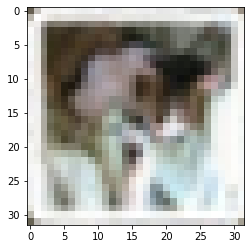

'label: ship / prediction: ship (99.999%)'

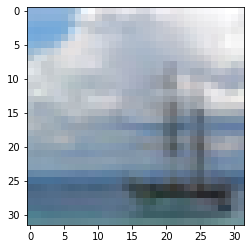

'label: car / prediction: car (94.895%)'

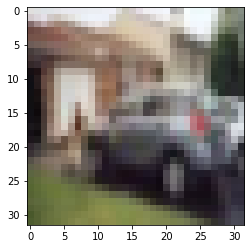

'label: ship / prediction: ship (99.998%)'

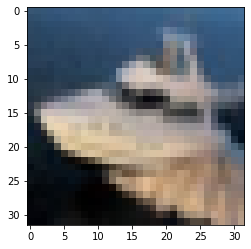

'label: horse / prediction: horse (99.986%)'

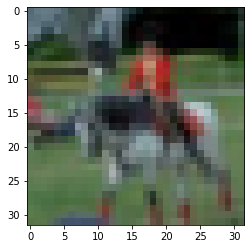

'label: bird / prediction: bird (99.975%)'

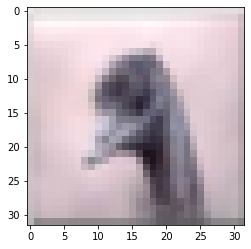

'label: car / prediction: car (99.998%)'

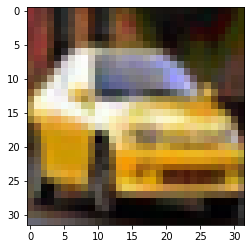

'label: deer / prediction: deer (99.997%)'

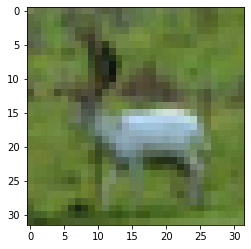

'label: dog / prediction: dog (99.999%)'

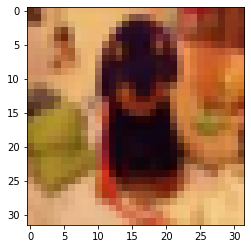

'label: deer / prediction: deer (100.000%)'

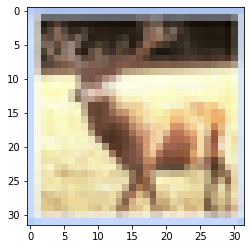

'label: plane / prediction: cat (79.195%)'

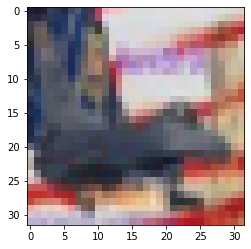

'label: bird / prediction: bird (99.997%)'

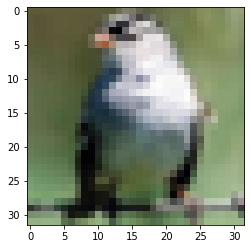

'label: frog / prediction: frog (99.989%)'

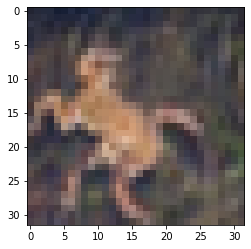

'label: dog / prediction: deer (99.856%)'

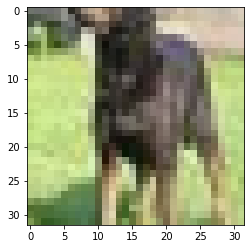

'label: horse / prediction: horse (100.000%)'

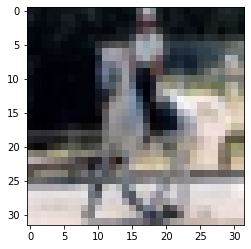

'label: cat / prediction: dog (41.670%)'

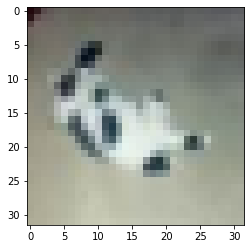

'label: deer / prediction: deer (99.995%)'

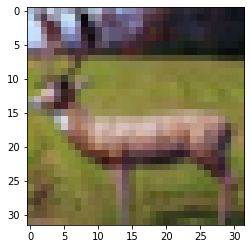

'label: deer / prediction: deer (99.999%)'

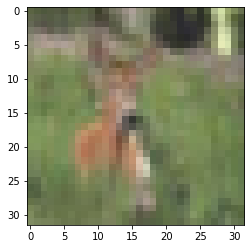

'label: deer / prediction: deer (99.998%)'

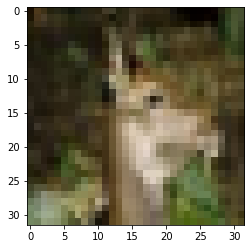

'label: frog / prediction: frog (100.000%)'

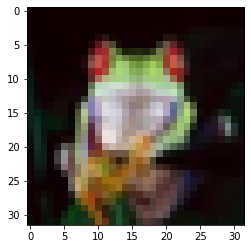

'label: cat / prediction: cat (99.999%)'

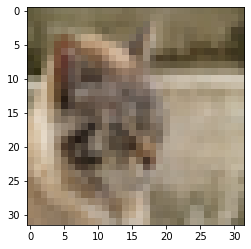

'label: deer / prediction: deer (99.915%)'

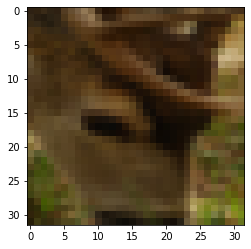

'label: cat / prediction: cat (99.993%)'

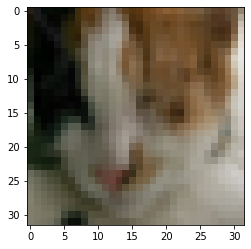

'label: truck / prediction: truck (100.000%)'

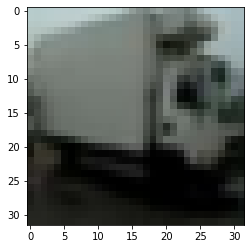

'label: frog / prediction: frog (99.999%)'

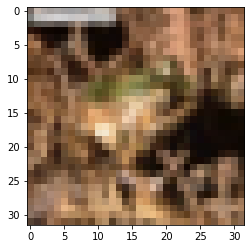

'label: car / prediction: car (99.997%)'

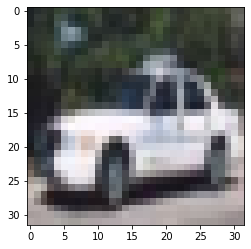

'label: deer / prediction: deer (99.997%)'

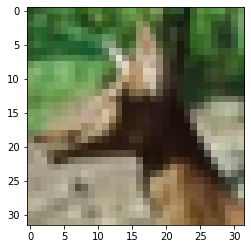

'label: dog / prediction: dog (99.990%)'

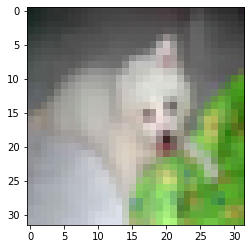

'label: deer / prediction: deer (99.999%)'

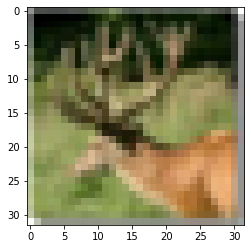

'label: deer / prediction: deer (99.999%)'

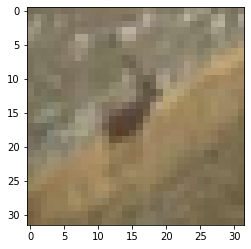

'label: dog / prediction: dog (99.995%)'

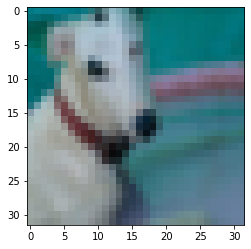

'label: car / prediction: car (100.000%)'

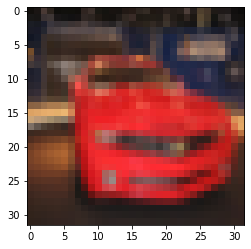

'label: plane / prediction: plane (99.993%)'

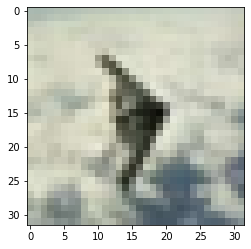

'label: deer / prediction: deer (99.993%)'

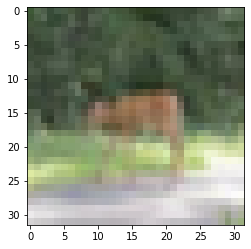

'label: horse / prediction: horse (99.999%)'

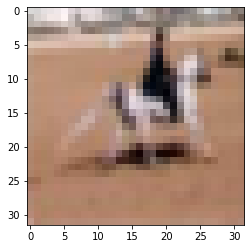

'label: car / prediction: car (99.998%)'

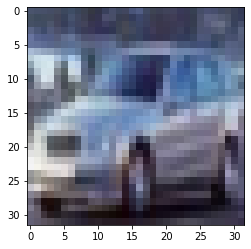

'label: ship / prediction: ship (99.998%)'

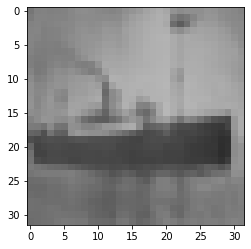

'label: plane / prediction: plane (99.997%)'

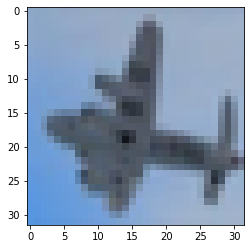

'label: car / prediction: truck (73.289%)'

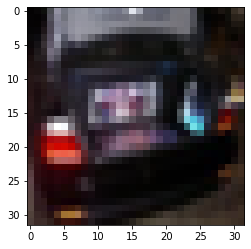

'label: ship / prediction: ship (100.000%)'

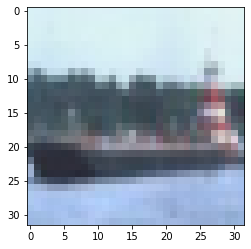

'label: horse / prediction: horse (99.994%)'

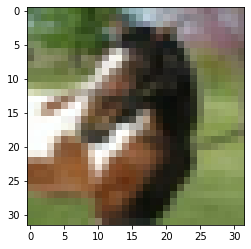

'label: ship / prediction: ship (99.996%)'

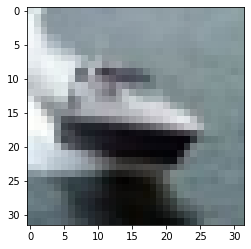

'label: horse / prediction: horse (99.998%)'

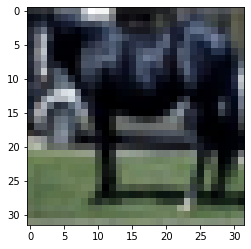

'label: deer / prediction: deer (99.994%)'

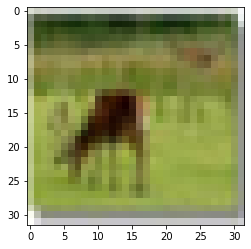

'label: cat / prediction: cat (99.999%)'

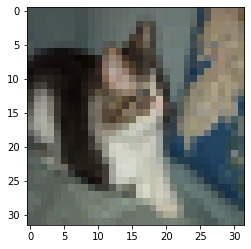

'label: plane / prediction: plane (100.000%)'

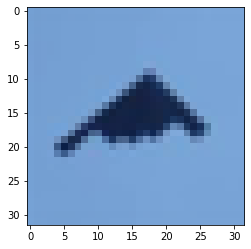

'label: cat / prediction: cat (99.999%)'

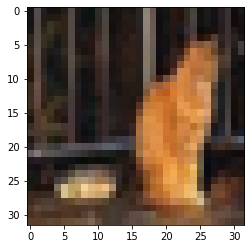

'label: car / prediction: car (99.999%)'

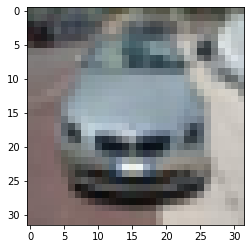

'label: deer / prediction: deer (99.992%)'

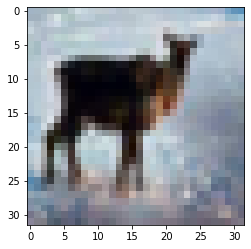

'label: deer / prediction: deer (100.000%)'

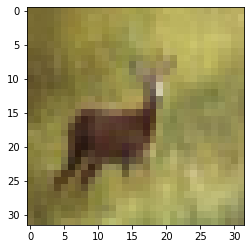

'label: frog / prediction: frog (99.999%)'

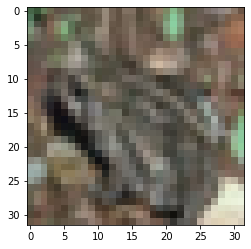

'label: frog / prediction: frog (99.998%)'

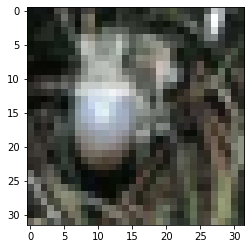

'label: deer / prediction: deer (100.000%)'

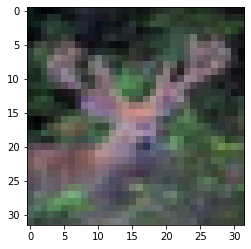

'label: deer / prediction: deer (99.983%)'

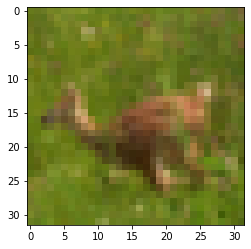

'label: dog / prediction: dog (99.999%)'

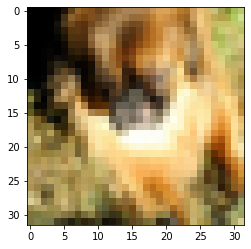

'label: truck / prediction: truck (100.000%)'

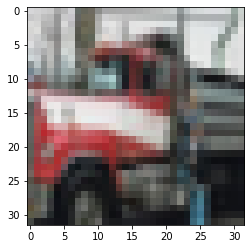

'label: cat / prediction: cat (99.968%)'

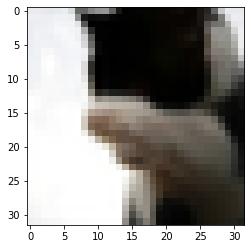

'label: car / prediction: car (99.999%)'

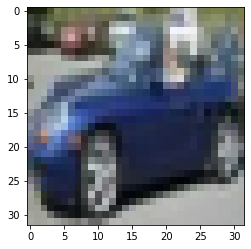

'label: bird / prediction: bird (99.998%)'

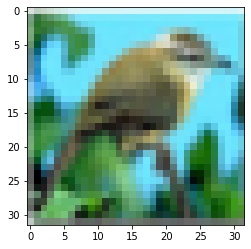

'label: deer / prediction: deer (99.959%)'

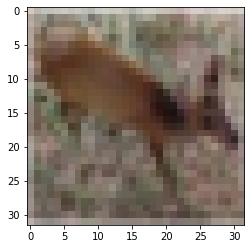

'label: truck / prediction: truck (99.996%)'

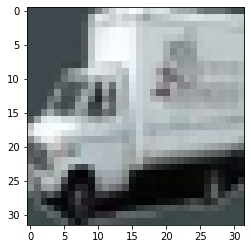

'label: ship / prediction: ship (99.999%)'

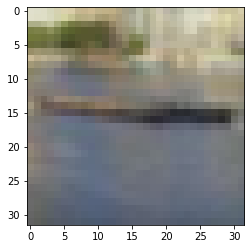

'label: plane / prediction: plane (100.000%)'

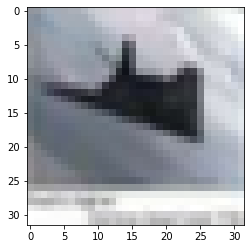

'label: truck / prediction: truck (99.999%)'

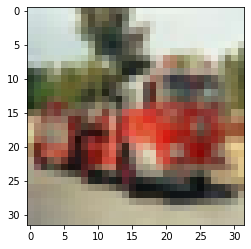

'label: deer / prediction: deer (100.000%)'

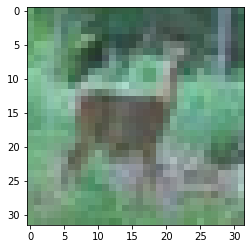

'label: plane / prediction: truck (67.260%)'

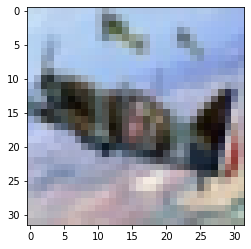

'label: ship / prediction: ship (100.000%)'

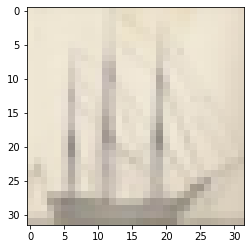

'label: dog / prediction: dog (99.984%)'

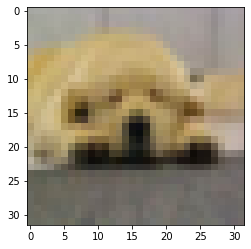

'label: car / prediction: car (99.998%)'

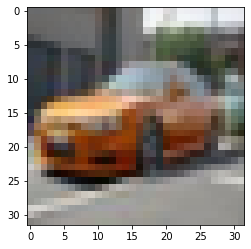

'label: frog / prediction: frog (99.999%)'

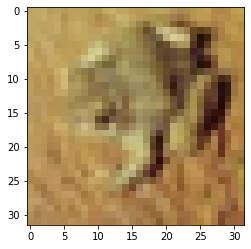

'label: bird / prediction: bird (99.959%)'

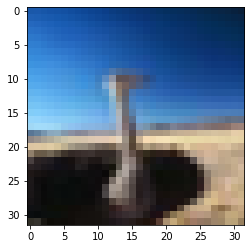

'label: plane / prediction: plane (100.000%)'

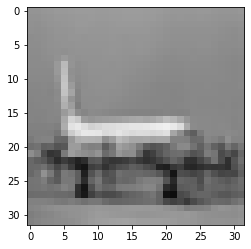

'label: horse / prediction: horse (99.998%)'

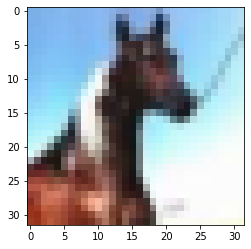

'label: truck / prediction: truck (100.000%)'

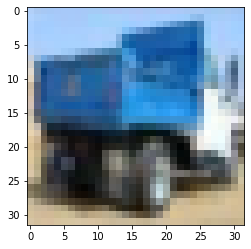

'label: cat / prediction: cat (99.993%)'

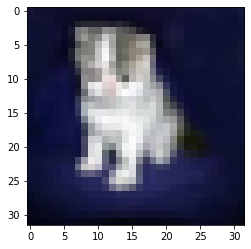

'label: plane / prediction: plane (99.982%)'

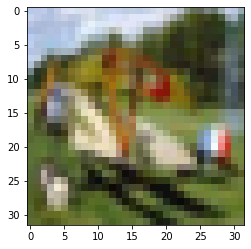

'label: cat / prediction: cat (99.998%)'

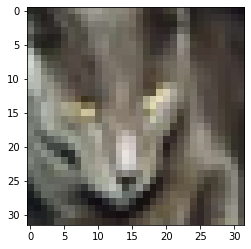

'label: dog / prediction: dog (99.997%)'

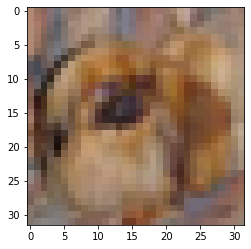

'label: cat / prediction: cat (99.970%)'

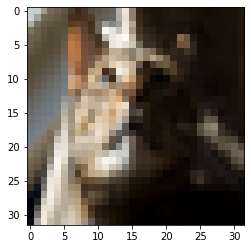

'label: truck / prediction: truck (99.999%)'

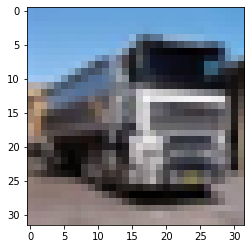

'label: dog / prediction: dog (72.842%)'

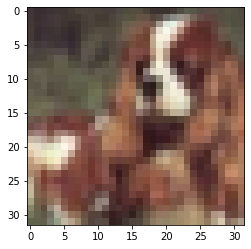

'label: truck / prediction: truck (99.997%)'

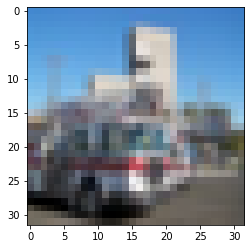

'label: frog / prediction: frog (99.996%)'

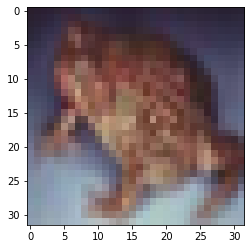

'label: car / prediction: car (99.996%)'

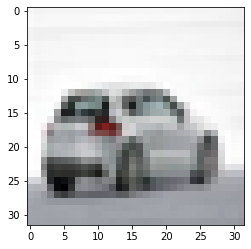

'label: bird / prediction: bird (100.000%)'

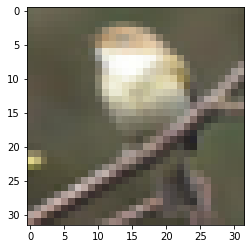

'label: car / prediction: truck (99.644%)'

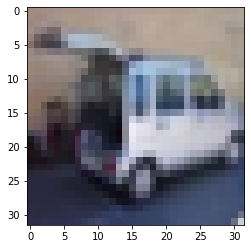

'label: truck / prediction: truck (100.000%)'

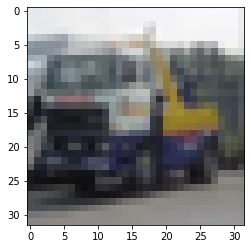

'label: horse / prediction: deer (97.844%)'

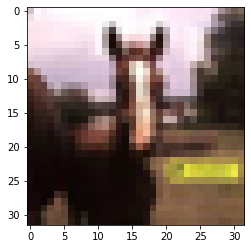

'label: horse / prediction: horse (99.995%)'

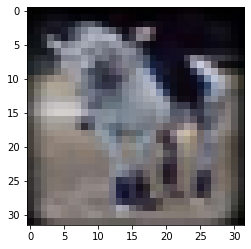

'label: deer / prediction: deer (99.997%)'

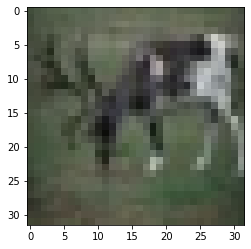

'label: deer / prediction: deer (99.997%)'

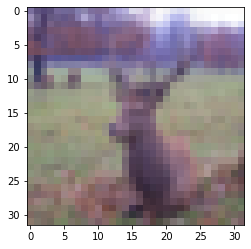

'label: dog / prediction: dog (99.998%)'

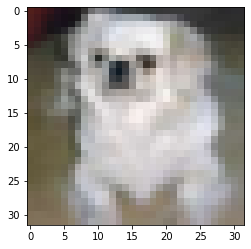

'label: cat / prediction: deer (90.018%)'

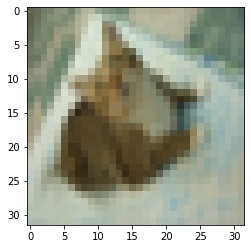

'label: ship / prediction: ship (99.995%)'

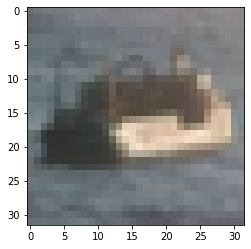

'label: car / prediction: car (99.981%)'

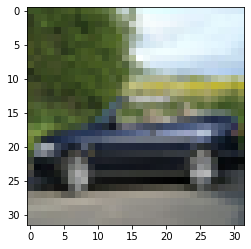

'label: horse / prediction: horse (95.770%)'

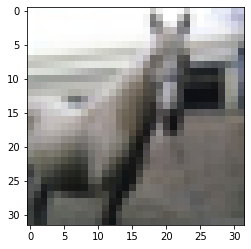

'label: horse / prediction: horse (99.993%)'

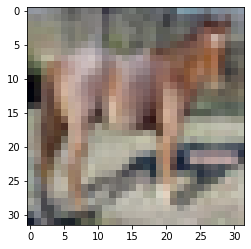

'label: frog / prediction: frog (99.994%)'

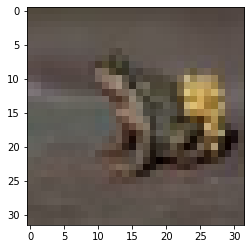

'label: plane / prediction: plane (99.994%)'

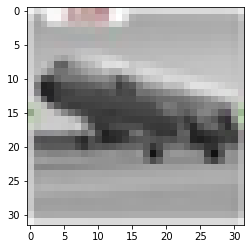

'label: cat / prediction: cat (99.992%)'

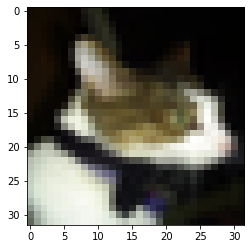

In [9]:
model.load_state_dict(torch.load("models/vgg-cifar-10.pth"))

with torch.no_grad():
  model.eval()
  _, validate_accuracy = validate()
  display("final accuracy: {:.3f}%".format(validate_accuracy * 100))
  
  for x, y in itertools.islice(DataLoader(cifar_10_test_dataset, batch_size=1, shuffle=True), 100):
    assert isinstance(x, torch.Tensor)
    assert isinstance(y, torch.Tensor)
    x = x.to(device)
    y = y.to(device)

    hypothesis = model(x)
    prediction = hypothesis.argmax(dim=1).item()
    prediction_percent = torch.softmax(hypothesis, dim=1).max(dim=1)[0].item() * 100

    display("label: {} / prediction: {} ({:.3f}%)".format(classes[y.item()], classes[prediction], prediction_percent))
    plt.imshow((x.cpu().view(3, 32, 32) * 0.5 + 0.5).permute(1, 2, 0))
    plt.show()

writer.close()